In [1]:
import numpy as np
import pandas as pd

In [2]:
N_exp=10000
N_con=10000

In [3]:
click_exp=pd.Series(np.random.binomial(1,0.4,size=N_exp))
click_con=pd.Series(np.random.binomial(1,0.2,size=N_con))

In [4]:
exp_id=pd.Series(np.repeat("exp",N_exp))
con_id=pd.Series(np.repeat("con",N_con))

In [6]:
df_exp=pd.concat([click_exp,exp_id],axis=1)
df_con=pd.concat([click_con,con_id],axis=1)

In [8]:
df_exp.columns=["click","group"]
df_con.columns=["click","group"]

In [9]:
print(df_exp)
print(df_con)

      click group
0         0   exp
1         0   exp
2         0   exp
3         0   exp
4         0   exp
...     ...   ...
9995      1   exp
9996      0   exp
9997      1   exp
9998      1   exp
9999      0   exp

[10000 rows x 2 columns]
      click group
0         0   con
1         0   con
2         0   con
3         0   con
4         0   con
...     ...   ...
9995      0   con
9996      0   con
9997      0   con
9998      1   con
9999      0   con

[10000 rows x 2 columns]


In [10]:
df_ab_test=pd.concat([df_exp,df_con],axis=0).reset_index(drop=True)
print(df_ab_test)

       click group
0          0   exp
1          0   exp
2          0   exp
3          0   exp
4          0   exp
...      ...   ...
19995      0   con
19996      0   con
19997      0   con
19998      1   con
19999      0   con

[20000 rows x 2 columns]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


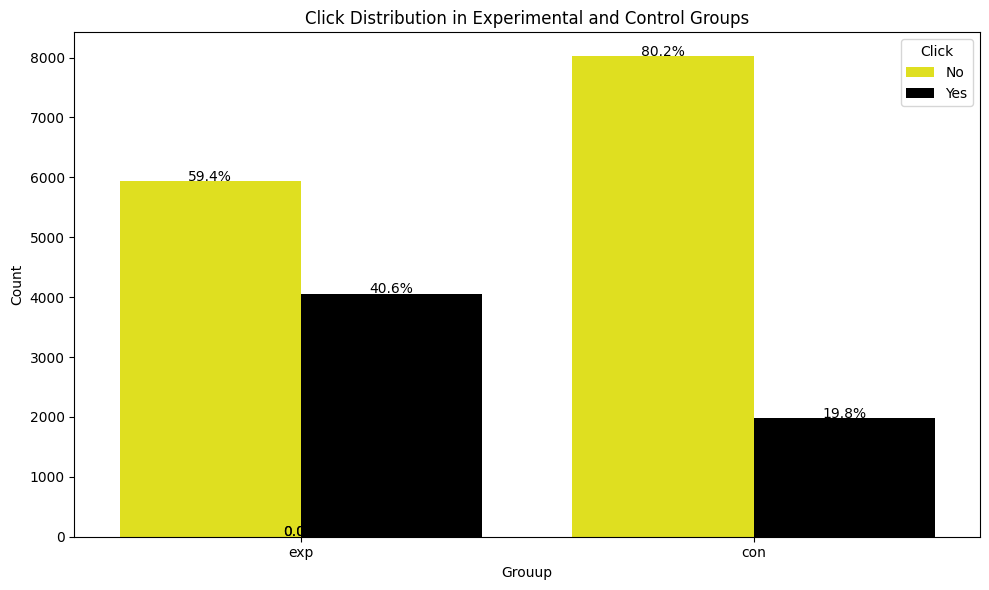

In [29]:
palette={0:'yellow',1:'black'}
plt.figure(figsize=(10,6))
ax=sns.countplot(x='group',hue='click',data=df_ab_test,palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Grouup')
plt.ylabel('Count')
plt.legend(title='Click',labels=['No','Yes'])

group_counts=df_ab_test.groupby(['group']).size()
group_click_counts=df_ab_test.groupby(['group','click']).size().reset_index(name='count')

for p in ax.patches:
    height=p.get_height()
    group='exp' if p.get_x()<0.5 else 'con'
    click=1 if p.get_x()%1>0.5 else 0
    total=group_counts.loc[group]
    percentage=100*height/total
    ax.text(p.get_x()+p.get_width()/2.,height+5,f'{percentage:.1f}%',ha="center",color="black")

plt.tight_layout()
plt.show()

Calculating total number of clicks per group by summing clicks

In [11]:
print(df_ab_test.groupby("group")["click"].sum())
x_con=df_ab_test.groupby("group")["click"].sum().loc["con"]
x_exp=df_ab_test.groupby("group")["click"].sum().loc["exp"]

group
con    1980
exp    4058
Name: click, dtype: int32


In [12]:
print("Number of clicks in control: ",x_con)
print("Number of clicks in experimental: ",x_exp)



Number of clicks in control:  1980
Number of clicks in experimental:  4058


Calculating Pooled Estimates for Clicks per Group

In [13]:
p_con_hat=x_con/N_con
p_exp_hat=x_exp/N_exp
print("Click probablity in control group: ",p_con_hat)
print("Click probablity in experimental group: ",p_exp_hat)

Click probablity in control group:  0.198
Click probablity in experimental group:  0.4058


In [14]:
p_pooled_hat=(x_con+x_exp)/(N_con+N_exp)

Calculating Pooled Variance

In [15]:
pooled_variance=p_pooled_hat*(1-p_pooled_hat)*(1/N_con+1/N_exp)
print("p_pooled is: ",p_pooled_hat)
print("pooled variance is: ",pooled_variance)

p_pooled is:  0.3019
pooled variance is:  4.2151278e-05


Calculating Standard Error and Test Statistics

In [16]:
#computing standard error of test
SE=np.sqrt(pooled_variance)
print("Standard Error is: ",SE)

Standard Error is:  0.006492401558745423


In [17]:
#computing test statistics of z-test
Test_stat=(p_con_hat-p_exp_hat)/SE
print("Test Sample for 2-sample z-test is: ",Test_stat)

Test Sample for 2-sample z-test is:  -32.006646249428044


In [35]:
alpha=0.05
delta=0.1

In [19]:
from scipy.stats import norm

In [20]:
#crirtical value of z-test
z_crit=norm.ppf(1-alpha/2)
print("Z-critical value from standard normal distribution: ",z_crit)

Z-critical value from standard normal distribution:  1.959963984540054


Calculating p-value of z-test

In [30]:
#calculating p value
p_value=norm.sf(abs(Test_stat))

def is_statistical_significance(p_value,alpha):
    print(f"Print value of 2-sample z-test is: ",round(p_value,3))
    if p_value<=alpha:
        print("There is statistical significance")
    else:
        print("There is no statistical significance")

is_statistical_significance(p_value,alpha)



Print value of 2-sample z-test is:  0.0
There is statistical significance


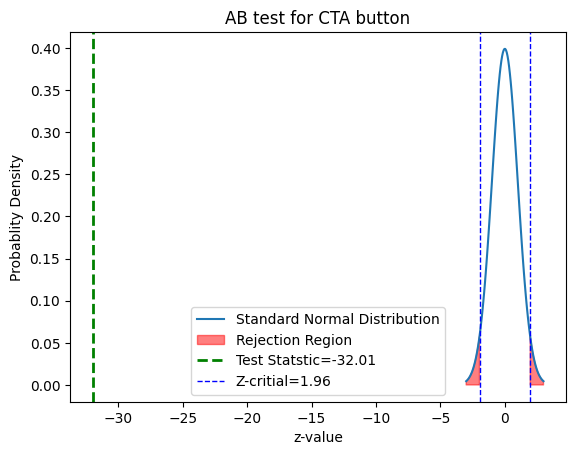

In [33]:
#parameters for standard normal distribution
mu=0 #mean
sigma=1 #standard deviation
x=np.linspace(mu-3*sigma,mu+3*sigma,100)
y=norm.pdf(x,mu,sigma)
plt.plot(x,y,label='Standard Normal Distribution')
#shade rejection region
plt.fill_between(x,y,where=(x>z_crit)|(x<-z_crit),color='red',alpha=0.5,label='Rejection Region')
#adding test statistics
plt.axvline(Test_stat,color='green',linestyle='dashed',linewidth=2,label=f'Test Statstic={Test_stat:.2f}')
#adding z-citical values
plt.axvline(z_crit,color='blue',linestyle='dashed',linewidth=1,label=f'Z-critial={z_crit:.2f}')
plt.axvline(-z_crit,color='blue',linestyle='dashed',linewidth=1)

#adding labels and title
plt.xlabel('z-value')
plt.ylabel('Probablity Density')
plt.title('AB test for CTA button')
plt.legend()

plt.show()

Calculating confidence interval of test

In [22]:
CI=[round((p_exp_hat-p_con_hat)-SE*z_crit,3),round((p_exp_hat-p_con_hat)+SE*z_crit,3)]
print("Confidence interval of 2 sample z-test is ",CI)

Confidence interval of 2 sample z-test is  [0.195, 0.221]


Testing for Practical Significance in A/B Testing

In [39]:
def is_practically_signifiant(delta,CI_95):
    lower_bound_CI=CI_95[0]
    if delta>=lower_bound_CI:
        print(f'We have practical significance!')
        return True
    else:
        print(f'We do nothave practical significance!')
        return False
    
significance=is_practically_signifiant(delta,CI_95)
print("Lower bound of 95% confidence interval is ",CI_95[0])


We have practical significance!
Lower bound of 95% confidence interval is  0.04
